In [1]:
import sys
import os
import logging
import ast
import re

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)
pd.set_option('display.max_colwidth', None)
from scipy import stats
from scipy.special import rel_entr

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

In [2]:
def set_style(fsz=14):
    sns.set_context("paper")    
    plt.rc('font', family='Linux Libertine')
    sns.set_style("ticks", {"xtick.major.size": 3, "ytick.major.size": 3})
    
    plt.rc('font', size=fsz, family='Linux Libertine')
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.rcParams['hatch.linewidth'] = 2  # previous pdf hatch linewidth
    
def set_size(fig, width=6, height=4):
    fig.set_size_inches(width, height)
    plt.tight_layout()
    
VIZ_DIR = "/scratchNVM0/ndhuynh/data/figs/"
def save_fig(fig, filename):
    fig.savefig(VIZ_DIR + filename, dpi=300, format='pdf', bbox_inches='tight')

In [3]:
sys.path.insert(1, '/scratchNVM0/ndhuynh/robust-lsm-tuning/endure')
from data.data_provider import DataProvider
from data.data_exporter import DataExporter
from robust.workload_uncertainty import WorkloadUncertainty
from lsm_tree.cost_function import CostFunction
from lsm_tree.nominal import NominalWorkloadTuning

config = DataProvider.read_config('/scratchNVM0/ndhuynh/robust-lsm-tuning/endure/config/robust-lsm-trees.yaml')
de = DataExporter(config)

# Generating Workloads for Exp02 Exp03

In [4]:
def apply_design(d, cf, z0, z1, q, w):
    cf.z0, cf.z1, cf.q, cf.w = z0, z1, q, w
    cost = cf.calculate_cost(d['M_filt'] / cf.N, np.ceil(d['T']), d['is_leveling_policy'])

    return cost

def get_cumulative_data(df, wl_idx, robust_rho, samples):
    df_sample = df[(df.workload_idx == wl_idx) & (df.robust_rho == robust_rho)]
    sessions = []
    sessions.append(df_sample[df_sample.z0_s + df_sample.z1_s > 0.8].sample(samples, replace=True, random_state=0))
    sessions.append(df_sample[df_sample.q_s > 0.8].sample(samples, replace=True, random_state=0))
    sessions.append(df_sample[df_sample.z0_s > 0.8].sample(samples, replace=True, random_state=0))
    sessions.append(df_sample[df_sample.z1_s > 0.8].sample(samples, replace=True, random_state=0))
    sessions.append(df_sample[df_sample.w_s > 0.8].sample(samples, replace=True, random_state=0))
    sessions.append(df_sample[df_sample.rho_hat < 0.2].sample(samples, replace=True, random_state=0))
    
    data = pd.concat(sessions, ignore_index=True)
    data[['robust_cost_cum', 'nominal_cost_cum']] = data[['robust_cost', 'nominal_cost']].cumsum()
    
    w_hat = data[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values
    w = ast.literal_eval(data.iloc[0].w)
    w0 = [w['z0'], w['z1'], w['q'], w['w']]
    distance = np.sum(rel_entr(w_hat, w0))

    cfg = config['lsm_tree_config'].copy()
    cfg['N'] = df.iloc[0].N
    cfg['M'] = df.iloc[0].M
    cf = CostFunction(**cfg, z0=w_hat[0], z1=w_hat[1], q=w_hat[2], w=w_hat[3])

    designer = NominalWorkloadTuning(cf)
    design_nom_s = designer.get_nominal_design()
    
    data['nominal_perfect_cost'] = data.apply(lambda row: apply_design(design_nom_s, cf, row['z0_s'], row['z1_s'], row['q_s'], row['w_s']), axis=1)
    data['nominal_perfect_cost_cum'] = data['nominal_perfect_cost'].cumsum()
    data['nominal_perfect_T'] = design_nom_s['T']
    data['nominal_perfect_m_filt'] = design_nom_s['M_filt']
    data['nominal_perfect_is_leveling_policy'] = design_nom_s['is_leveling_policy']
    
    design_robust = {}
    design_robust['T'] = np.ceil(data['robust_T'].iloc[0])
    design_robust['M_filt'] = data['robust_m_filt'].iloc[0]
    design_robust['is_leveling_policy'] = data['robust_is_leveling_policy'].iloc[0]
    data['robust_cost'] = data.apply(lambda row: apply_design(design_robust, cf, row['z0_s'], row['z1_s'], row['q_s'], row['w_s']), axis=1)
    
    design_nominal = {}
    design_nominal['T'] = np.ceil(data['nominal_T'].iloc[0])
    design_nominal['M_filt'] = data['nominal_m_filt'].iloc[0]
    design_nominal['is_leveling_policy'] = data['nominal_is_leveling_policy'].iloc[0]
    data['nominal_cost'] = data.apply(lambda row: apply_design(design_nominal, cf, row['z0_s'], row['z1_s'], row['q_s'], row['w_s']), axis=1)
    
    return data, sessions

In [5]:
dp = DataProvider(config)
df = dp.read_csv('exp_01_1e8.csv')
df['robust_cost'] = np.around(df['robust_cost'], 4)
df['nominal_cost'] = np.around(df['nominal_cost'], 4)
df['robust_rho'] = np.around(df['robust_rho'], 2)
df['z_score'] = df.groupby(['workload_idx', 'robust_rho']).rho_hat.transform(lambda x: np.abs(stats.zscore(x)))
df[['z0_s', 'z1_s', 'q_s', 'w_s']] = df['w_hat'].str.extract(r"{'z0': ([0-9.]+), 'z1': ([0-9.]+), 'q': ([0-9.]+), 'w': ([0-9.]+)}")
df[['z0_s', 'z1_s', 'q_s', 'w_s']] = df[['z0_s', 'z1_s', 'q_s', 'w_s']].astype(np.float64)
df.describe()

,workload_idx,N,M,robust_rho,robust_m_filt,robust_T,robust_exit_mode,nominal_m_filt,nominal_T,rho_hat,sample_idx,nominal_cost,robust_cost,z_score,z0_s,z1_s,q_s,w_s
count,8.640000e+06,8640000.0,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06,8.640000e+06
mean,8.500000e+00,100000000.0,1.500000e+09,1.875000e+00,1.710512e+08,6.057576e+00,2.083333e-02,5.519066e+08,2.058787e+01,1.370811e+00,4.999500e+03,5.159615e+00,2.701763e+00,7.930993e-01,2.513584e-01,2.511446e-01,2.481513e-01,2.493440e-01
std,5.188128e+00,0.0,4.082483e+08,1.152443e+00,1.662915e+08,7.905549e+00,4.325113e-01,3.955914e+08,2.716106e+01,8.458691e-01,2.886751e+03,3.894359e+00,1.294931e+00,6.090924e-01,1.402882e-01,1.416221e-01,1.418426e-01,1.408217e-01
min,0.000000e+00,100000000.0,1.000000e+09,0.000000e+00,1.000000e+08,2.000000e+00,0.000000e+00,0.000000e+00,2.298706e+00,1.330878e-04,0.000000e+00,1.447000e-01,2.058000e-01,2.967082e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,100000000.0,1.000000e+09,9.375000e-01,1.000000e+08,4.659797e+00,0.000000e+00,2.631811e+08,5.132782e+00,6.975509e-01,2.499750e+03,2.457800e+00,2.213400e+00,3.254932e-01,1.453750e-01,1.453000e-01,1.385000e-01,1.435750e-01
50%,8.500000e+00,100000000.0,1.500000e+09,1.875000e+00,1.000000e+08,4.998932e+00,0.000000e+00,5.013878e+08,6.454354e+00,1.300226e+00,4.999500e+03,3.296900e+00,2.556000e+00,6.752890e-01,2.509000e-01,2.507000e-01,2.474500e-01,2.500000e-01
75%,1.300000e+01,100000000.0,2.000000e+09,2.812500e+00,1.000000e+08,5.095223e+00,0.000000e+00,8.892605e+08,1.728771e+01,1.927153e+00,7.499250e+03,7.334100e+00,2.921200e+00,1.123176e+00,3.444000e-01,3.432500e-01,3.412000e-01,3.413000e-01
max,1.700000e+01,100000000.0,2.000000e+09,3.750000e+00,1.288188e+09,1.000000e+02,9.000000e+00,1.289815e+09,1.000000e+02,4.330997e+00,9.999000e+03,3.458760e+01,4.146120e+01,6.634283e+00,9.327000e-01,8.971000e-01,8.788000e-01,9.029000e-01


In [6]:
sample_wl = []

samples = 5
# wl_rho = [(4, 2), (5, 1), (15, 0.5), (11, 0.25), (17, 0.5), (0, 0.25)]
wl_rho = [(17, 0.5)]
for widx, rho in wl_rho:
    data, _ = get_cumulative_data(df, widx, rho, samples)
    sample_wl.append(data)

sample_wl = pd.concat(sample_wl, ignore_index=True)
de.export_csv_file(sample_wl, 'experiment_03_wls.csv')
sample_wl


,workload_idx,w,N,M,robust_rho,robust_m_filt,robust_T,robust_is_leveling_policy,robust_exit_mode,nominal_m_filt,nominal_T,nominal_is_leveling_policy,rho_hat,w_hat,sample_idx,nominal_cost,robust_cost,z_score,z0_s,z1_s,q_s,w_s,robust_cost_cum,nominal_cost_cum,nominal_perfect_cost,nominal_perfect_cost_cum,nominal_perfect_T,nominal_perfect_m_filt,nominal_perfect_is_leveling_policy
0,17,"{'z0': 0.3, 'z1': 0.01, 'q': 0.01, 'w': 0.6}",100000000.0,1.500000e+09,0.5,2.141219e+08,2.814246,True,0,9.104952e+08,11.323614,False,1.286409,"{'z0': 0.6491, 'z1': 0.2807, 'q': 0.0, 'w': 0.0702}",8321,0.542254,1.126905,0.367902,0.6491,0.2807,0.0000,0.0702,1.1411,0.5124,0.768651,0.768651,4.066379,4.090492e+08,True
1,17,"{'z0': 0.3, 'z1': 0.01, 'q': 0.01, 'w': 0.6}",100000000.0,1.500000e+09,0.5,2.141219e+08,2.814246,True,0,9.104952e+08,11.323614,False,1.886529,"{'z0': 0.3317, 'z1': 0.4712, 'q': 0.0962, 'w': 0.101}",5026,4.622922,1.743468,0.579031,0.3317,0.4712,0.0962,0.1010,2.8666,4.1747,1.448614,2.217265,4.066379,4.090492e+08,True
2,17,"{'z0': 0.3, 'z1': 0.01, 'q': 0.01, 'w': 0.6}",100000000.0,2.000000e+09,0.5,2.670636e+08,2.778088,True,0,1.025389e+09,11.954590,False,2.134145,"{'z0': 0.2992, 'z1': 0.5748, 'q': 0.0079, 'w': 0.1181}",2191,1.191130,1.320348,0.969746,0.2992,0.5748,0.0079,0.1181,4.0774,5.1879,1.224528,3.441793,4.066379,4.090492e+08,True
3,17,"{'z0': 0.3, 'z1': 0.01, 'q': 0.01, 'w': 0.6}",100000000.0,2.000000e+09,0.5,2.670636e+08,2.778088,True,0,1.025389e+09,11.954590,False,1.132842,"{'z0': 0.5625, 'z1': 0.2891, 'q': 0.0156, 'w': 0.1328}",404,1.270118,1.352272,0.610216,0.5625,0.2891,0.0156,0.1328,5.2699,6.1793,1.105991,4.547784,4.066379,4.090492e+08,True
4,17,"{'z0': 0.3, 'z1': 0.01, 'q': 0.01, 'w': 0.6}",100000000.0,2.000000e+09,0.5,2.670636e+08,2.778088,True,0,1.025389e+09,11.954590,False,2.024098,"{'z0': 0.3978, 'z1': 0.4696, 'q': 0.0939, 'w': 0.0387}",7699,4.436032,1.591485,0.796102,0.3978,0.4696,0.0939,0.0387,6.7493,9.5523,1.173903,5.721687,4.066379,4.090492e+08,True
5,17,"{'z0': 0.3, 'z1': 0.01, 'q': 0.01, 'w': 0.6}",100000000.0,1.500000e+09,0.5,2.141219e+08,2.814246,True,0,9.104952e+08,11.323614,False,3.385534,"{'z0': 0.0566, 'z1': 0.0, 'q': 0.8302, 'w': 0.1132}",3844,33.724783,5.662775,2.944319,0.0566,0.0000,0.8302,0.1132,12.3073,35.2760,4.255782,9.977469,4.066379,4.090492e+08,True
6,17,"{'z0': 0.3, 'z1': 0.01, 'q': 0.01, 'w': 0.6}",100000000.0,1.500000e+09,0.5,2.141219e+08,2.814246,True,0,9.104952e+08,11.323614,False,3.813264,"{'z0': 0.0273, 'z1': 0.1091, 'q': 0.8364, 'w': 0.0273}",5427,33.942124,5.520583,3.619237,0.0273,0.1091,0.8364,0.0273,17.7511,61.1851,3.999871,13.977340,4.066379,4.090492e+08,True
7,17,"{'z0': 0.3, 'z1': 0.01, 'q': 0.01, 'w': 0.6}",100000000.0,2.000000e+09,0.5,2.670636e+08,2.778088,True,0,1.025389e+09,11.954590,False,3.385534,"{'z0': 0.0566, 'z1': 0.0, 'q': 0.8302, 'w': 0.1132}",3844,33.724783,5.662775,2.944319,0.0566,0.0000,0.8302,0.1132,23.1036,86.0200,4.255782,18.233122,4.066379,4.090492e+08,True
8,17,"{'z0': 0.3, 'z1': 0.01, 'q': 0.01, 'w': 0.6}",100000000.0,1.000000e+09,0.5,1.446009e+08,2.879447,True,0,7.248817e+08,9.795177,False,3.691342,"{'z0': 0.0, 'z1': 0.1205, 'q': 0.8072, 'w': 0.0723}",199,32.845797,5.465133,3.426856,0.0000,0.1205,0.8072,0.0723,28.6991,111.1587,4.075249,22.308371,4.066379,4.090492e+08,True
9,17,"{'z0': 0.3, 'z1': 0.01, 'q': 0.01, 'w': 0.6}",100000000.0,1.000000e+09,0.5,1.446009e+08,2.879447,True,0,7.248817e+08,9.795177,False,3.385534,"{'z0': 0.0566, 'z1': 0.0, 'q': 0.8302, 'w': 0.1132}",3844,33.724783,5.662775,2.944319,0.0566,0.0000,0.8302,0.1132,34.5097,136.9554,4.255782,26.564153,4.066379,4.090492e+08,True


# Plotting Data

In [7]:
def process_ios(df):
    PAGESIZE = 4096
    nominal_compaction_ios = np.sum((df['nominal_compact_read'] + df['nominal_compact_write']) / PAGESIZE)
    robust_compaction_ios = np.sum((df['robust_compact_read'] + df['robust_compact_write']) / PAGESIZE)
    workload_weight = df['w_s'] / df['w_s'].sum()
    df['nominal_write_io'] = (workload_weight * nominal_compaction_ios) + ((df['nominal_bytes_written'] + df['nominal_flush_written']) / PAGESIZE)
    df['robust_write_io'] = (workload_weight * robust_compaction_ios) + ((df['robust_bytes_written'] + df['robust_flush_written']) / PAGESIZE)
    df['nominal_io'] = df['nominal_blocks_read'] + df['nominal_write_io']
    df['robust_io'] = df['robust_blocks_read'] +  df['robust_write_io'] 
    
    return df


def plot_cost_sessions(df, samples, num_operations, wl_idx, robust_rho, readonly=False):
    df = df[(df.workload_idx == wl_idx) & (df.robust_rho == robust_rho)].copy().reset_index()
    num_sessions = df.shape[0] / samples
    
    means = []
    for idx in range(0, data.shape[0], samples):
        means.append(df[(df.workload_idx == wl_idx) & (df.robust_rho == robust_rho)].iloc[idx:idx+samples][['z0_s', 'z1_s', 'q_s', 'w_s']].mean())
        
    w_hat = df[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values
    w = ast.literal_eval(df.iloc[0].w)
    w0 = [w['z0'], w['z1'], w['q'], w['w']]
    distance = np.sum(rel_entr(w_hat, w0))

    nom_policy = 'Leveling' if df.iloc[0].nominal_is_leveling_policy else 'Tiering'
    robust_policy = 'Leveling' if df.iloc[0].robust_is_leveling_policy else 'Tiering'
    
    df = process_ios(df)
    y1, y2 = df['nominal_io'].values, df['robust_io'].values
        
    fig, axes = plt.subplots(ncols=1, nrows=2)
    system_ax, model_ax = axes
    
    for ax in axes:
        ax.set_xlim(left=-0.25, right=(num_sessions * samples) - 0.75)
        for bounds in np.arange(samples - 1, num_sessions * samples - 1, samples):
            ax.axvline(x=bounds + 0.5, linestyle='--', linewidth=4, color='tab:gray', alpha=0.5)
    
    # Systems Graph
    system_ax.text(0.565, 0.9, 'System', fontsize=16, transform=system_ax.transAxes)
    system_ax.set_xticklabels([])
    system_ax.set_xticks([])
    system_ax.plot(df.index.values, y1 / num_operations, marker='*', linewidth=1, color='black',     markersize=8, label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}, $\pi$: {nom_policy}')
    system_ax.plot(df.index.values, y2 / num_operations, marker='o', linewidth=1, color='tab:green', markersize=8, label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}, $\pi$: {robust_policy}')
    system_ax.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True, framealpha=1, edgecolor='black', fancybox=False, ncol=2)
    
    
    # Model Graph
    model_ax.text(0.565, 0.9, 'Model', fontsize=16, transform=model_ax.transAxes)
    y1, y2 = df.nominal_cost, df.robust_cost
    model_ax.plot(df.index.values, y1, marker='*', linewidth=1, color='black',     markersize=8, label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}, $\pi$: {nom_policy}')
    model_ax.plot(df.index.values, y2, marker='o', linewidth=1, color='tab:green', markersize=8, label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}, $\pi$: {robust_policy}')
    
    model_ax.set_xticks([(samples)/2 - 0.25] + [x + 0.5 for x in np.arange((samples/2) + samples - 1, num_sessions * samples - 1, samples)])
    model_ax.text(0.025, -0.22, f'({(means[0].z0_s * 100):.0f}%, {(means[0].z1_s * 100):.0f}%, {(means[0].q_s * 100):.0f}%, {(means[0].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)
    model_ax.text(0.200, -0.22, f'({(means[1].z0_s * 100):.0f}%, {(means[1].z1_s * 100):.0f}%, {(means[1].q_s * 100):.0f}%, {(means[1].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)
    model_ax.text(0.360, -0.22, f'({(means[2].z0_s * 100):.0f}%, {(means[2].z1_s * 100):.0f}%, {(means[2].q_s * 100):.0f}%, {(means[2].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)
    model_ax.text(0.535, -0.22, f'({(means[3].z0_s * 100):.0f}%, {(means[3].z1_s * 100):.0f}%, {(means[3].q_s * 100):.0f}%, {(means[3].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)
    model_ax.text(0.700, -0.22, f'({(means[4].z0_s * 100):.0f}%, {(means[4].z1_s * 100):.0f}%, {(means[4].q_s * 100):.0f}%, {(means[4].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)

    if readonly:
        model_ax.set_xticklabels(['1. Expected', '2. Reads', '3. Range', '4. Empty Reads', '5. Non-Empty Reads'])
    else:
        model_ax.set_xticklabels(['1. Reads', '2. Range', '3. Empty Reads', '4. Non-Empty Reads', '5. Writes', '6. Expected'])
        model_ax.text(0.870, -0.22, f'({(means[5].z0_s * 100):.0f}%, {(means[5].z1_s * 100):.0f}%, {(means[5].q_s * 100):.0f}%, {(means[5].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)
    
    fig.supylabel('Average I/Os per Query')
    
    system_ax.text(0.84, 0.90, '$w_{' + str(wl_idx) + '}:\ $' + f'({(w0[0] * 100):.0f}%, {(w0[1] * 100):.0f}%, {(w0[2] * 100):.0f}%, {(w0[3] * 100):.0f}%)', transform=system_ax.transAxes)
    system_ax.text(0.84, 0.78, '$\hat{w}:\ $' + f'({(w_hat[0] * 100):.0f}%, {(w_hat[1] * 100):.0f}%, {(w_hat[2] * 100):.0f}%, {(w_hat[3] * 100):.0f}%)', transform=system_ax.transAxes)
    
    model_ax.text(0.885, 0.75, '$I_{KL}(\hat{w}, w) :$' + f'{distance:.2f}', transform=model_ax.transAxes)
    model_ax.text(0.945, 0.88, r'$\rho :$' + f'{robust_rho:.2f}', transform=model_ax.transAxes)

    
    return fig, axes

# Plotting Single Experiment

In [8]:
wl_idx, robust_rho, samples, num_operations = (17, 0.5, 5, 100000)
data = dp.read_csv('exp_03_1e8.csv')

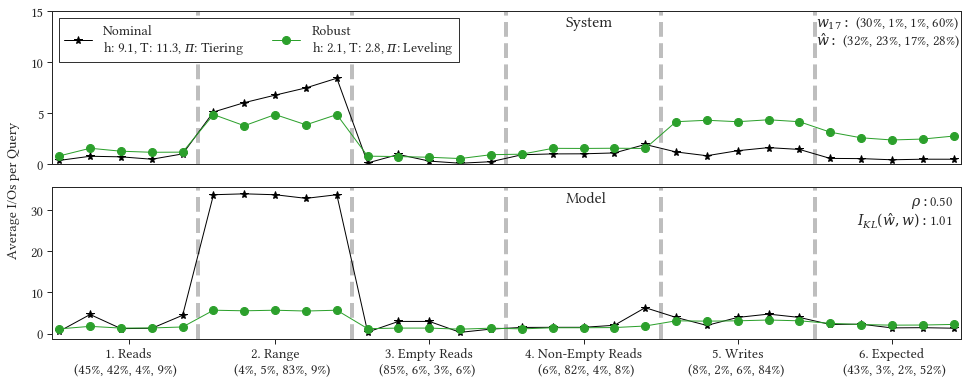

In [9]:
set_style()
fig, axes = plot_cost_sessions(data, samples, num_operations, wl_idx, robust_rho, readonly=False)
axes[0].set_ylim([0, 15])
# axes[1].set_ylim([0, 8])
set_size(fig, width=2*7, height=2*2.75)

workload_idx  robust_rho
4             2.00          30
5             1.00          30
11            0.25          30
15            0.50          30
dtype: int64


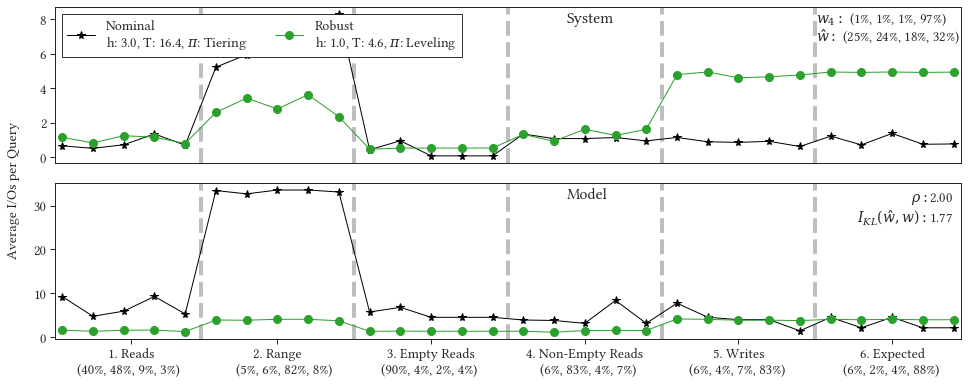

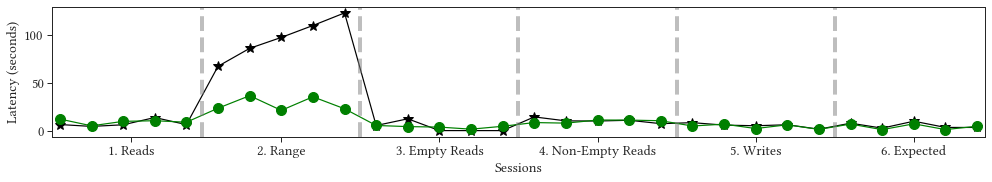

In [10]:
wl_idx, robust_rho, samples, num_operations = (4, 2, 5, 10000)

data = dp.read_csv('viz_data/exp07_10mill.csv')
data['nominal_ms'] = data['nominal_z0_ms'] + data['nominal_z1_ms'] + data['nominal_q_ms'] + data['nominal_w_ms']
data['robust_ms'] = data['robust_z0_ms'] + data['robust_z1_ms'] + data['robust_q_ms'] + data['robust_w_ms']
print(data.groupby(['workload_idx', 'robust_rho']).size())

d = data[(data.workload_idx == wl_idx) & (data.robust_rho == robust_rho)].reset_index()
set_style()
fig, axes = plot_cost_sessions(d, samples, num_operations, wl_idx, robust_rho, readonly=False)
# axes[0].set_ylim([0, 8])
# axes[1].set_ylim([0, 8])
set_size(fig, width=2*7, height=2*2.75)

fig, ax = plt.subplots()
ax.plot(d.index.values, d['nominal_ms'] / 100, '-*', markersize=10, color='black')
ax.plot(d.index.values, d['robust_ms']  / 100, '-o', markersize=10, color='green')

bounds = [5, 10, 15, 20, 25]
ax.set_xlim(left=-0.25, right=29.25)
for bound in bounds:
    ax.axvline(x=bound - 0.5, linestyle='--', linewidth=4, color='tab:gray', alpha=0.5)

ax.set_xticks([4.5 / 2, (4.5 + 9.5) / 2, (9.5 + 14.5) / 2, (14.5 + 19.5) / 2, (19.5 + 24.5) / 2, (24.5 + 29.5) / 2])
ax.set_xticklabels(['1. Reads', '2. Range', '3. Empty Reads', '4. Non-Empty Reads', '5. Writes', '6. Expected'])

ax.set_ylabel('Latency (seconds)')
ax.set_xlabel('Sessions')
set_size(fig, width=14, height=2.75)

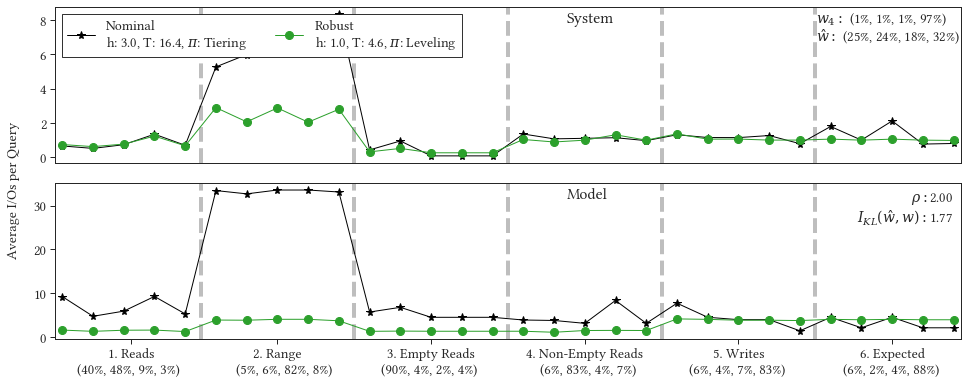

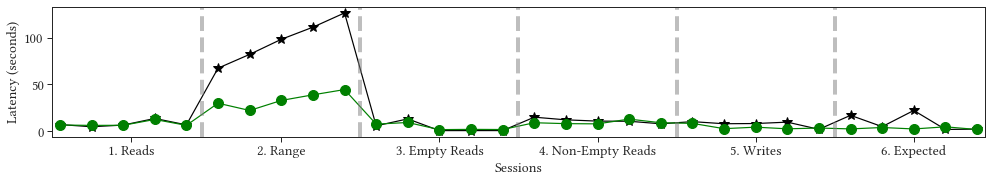

In [11]:
data = dp.read_csv('viz_data/exp08_10mill.csv')
data['nominal_ms'] = data['nominal_z0_ms'] + data['nominal_z1_ms'] + data['nominal_q_ms'] + data['nominal_w_ms']
data['robust_ms'] = data['robust_z0_ms'] + data['robust_z1_ms'] + data['robust_q_ms'] + data['robust_w_ms']
data.groupby(['workload_idx', 'robust_rho']).size()
d = data[(data.workload_idx == wl_idx) & (data.robust_rho == robust_rho)].reset_index()
fig, axes = plot_cost_sessions(d, samples, num_operations, wl_idx, robust_rho, readonly=False)
# axes[0].set_ylim([0, 7])
# axes[1].set_ylim([0, 8])
set_size(fig, width=2*7, height=2*2.75)

fig, ax = plt.subplots()
ax.plot(d.index.values, d['nominal_ms'] / 100, '-*', markersize=10, color='black')
ax.plot(d.index.values, d['robust_ms']  / 100, '-o', markersize=10, color='green')

bounds = [5, 10, 15, 20, 25]
ax.set_xlim(left=-0.25, right=29.25)
for bound in bounds:
    ax.axvline(x=bound - 0.5, linestyle='--', linewidth=4, color='tab:gray', alpha=0.5)

ax.set_xticks([4.5 / 2, (4.5 + 9.5) / 2, (9.5 + 14.5) / 2, (14.5 + 19.5) / 2, (19.5 + 24.5) / 2, (24.5 + 29.5) / 2])
ax.set_xticklabels(['1. Reads', '2. Range', '3. Empty Reads', '4. Non-Empty Reads', '5. Writes', '6. Expected'])

ax.set_ylabel('Latency (seconds)')
ax.set_xlabel('Sessions')
set_size(fig, width=14, height=2.75)

In [15]:
def apply_design(df, cf, z0, z1, q, w, mode='nominal'):
    cf.z0, cf.z1, cf.q, cf.w = z0, z1, q, w
    cost = cf.calculate_cost(df[f'{mode}_m_filt'] / cf.N, np.ceil(df[f'{mode}_T']), df[f'{mode}_is_leveling_policy'])
    return cost

def plot_cost_sessions(df, samples, num_operations, wl_idx, robust_rho, readonly=False):
    num_sessions = df.shape[0] / samples
    
    means = []
    for idx in range(0, data.shape[0], samples):
        means.append(df.iloc[idx:idx+samples][['z0_s', 'z1_s', 'q_s', 'w_s']].mean())
        
    w_hat = df[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values
    w0 = [df['z0'].iloc[0], df['z1'].iloc[0], df['q'].iloc[0], df['w'].iloc[0]]
    distance = np.sum(rel_entr(w_hat, w0))

    nom_policy = 'Leveling' if df.iloc[0].nominal_is_leveling_policy else 'Tiering'
    robust_policy = 'Leveling' if df.iloc[0].robust_is_leveling_policy else 'Tiering'
    
    df = process_ios(df)
    y1, y2 = df['nominal_io'].values, df['robust_io'].values
        
    fig, axes = plt.subplots(ncols=1, nrows=2)
    system_ax, model_ax = axes
    
    for ax in axes:
        ax.set_xlim(left=-0.25, right=(num_sessions * samples) - 0.75)
        for bounds in np.arange(samples - 1, num_sessions * samples - 1, samples):
            ax.axvline(x=bounds + 0.5, linestyle='--', linewidth=4, color='tab:gray', alpha=0.5)
            
    # Apply design for models
    cfg = config['lsm_tree_config'].copy()
    cfg['N'] = df.iloc[0].N
    cfg['M'] = df.iloc[0].M
    cf = CostFunction(**cfg, z0=w_hat[0], z1=w_hat[1], q=w_hat[2], w=w_hat[3])
    df['nominal_cost'] = df.apply(lambda row: apply_design(row, cf, row['z0_s'], row['z1_s'], row['q_s'], row['w_s'], 'nominal'), axis=1)
    df['robust_cost'] = df.apply(lambda row: apply_design(row, cf, row['z0_s'], row['z1_s'], row['q_s'], row['w_s'], 'robust'), axis=1)
    
    # Systems Graph
    system_ax.text(0.565, 0.9, 'System', fontsize=16, transform=system_ax.transAxes)
    system_ax.set_xticklabels([])
    system_ax.set_xticks([])
    system_ax.plot(df.index.values, y1 / num_operations, marker='*', linewidth=1, color='black',     markersize=8, label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}, $\pi$: {nom_policy}')
    system_ax.plot(df.index.values, y2 / num_operations, marker='o', linewidth=1, color='tab:green', markersize=8, label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}, $\pi$: {robust_policy}')
    system_ax.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True, framealpha=1, edgecolor='black', fancybox=False, ncol=2)
    
    # Model Graph
    model_ax.text(0.565, 0.9, 'Model', fontsize=16, transform=model_ax.transAxes)
    y1, y2 = df.nominal_cost, df.robust_cost
    model_ax.plot(df.index.values, y1, marker='*', linewidth=1, color='black',     markersize=8, label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}, $\pi$: {nom_policy}')
    model_ax.plot(df.index.values, y2, marker='o', linewidth=1, color='tab:green', markersize=8, label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}, $\pi$: {robust_policy}')
    
    model_ax.set_xticks([(samples)/2 - 0.25] + [x + 0.5 for x in np.arange((samples/2) + samples - 1, num_sessions * samples - 1, samples)])
    model_ax.text(0.025, -0.22, f'({(means[0].z0_s * 100):.0f}%, {(means[0].z1_s * 100):.0f}%, {(means[0].q_s * 100):.0f}%, {(means[0].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)
    model_ax.text(0.200, -0.22, f'({(means[1].z0_s * 100):.0f}%, {(means[1].z1_s * 100):.0f}%, {(means[1].q_s * 100):.0f}%, {(means[1].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)
    model_ax.text(0.360, -0.22, f'({(means[2].z0_s * 100):.0f}%, {(means[2].z1_s * 100):.0f}%, {(means[2].q_s * 100):.0f}%, {(means[2].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)
    model_ax.text(0.535, -0.22, f'({(means[3].z0_s * 100):.0f}%, {(means[3].z1_s * 100):.0f}%, {(means[3].q_s * 100):.0f}%, {(means[3].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)
    model_ax.text(0.700, -0.22, f'({(means[4].z0_s * 100):.0f}%, {(means[4].z1_s * 100):.0f}%, {(means[4].q_s * 100):.0f}%, {(means[4].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)

    if readonly:
        model_ax.set_xticklabels(['1. Expected', '2. Reads', '3. Range', '4. Empty Reads', '5. Non-Empty Reads'])
    else:
        model_ax.set_xticklabels(['1. Reads', '2. Range', '3. Empty Reads', '4. Non-Empty Reads', '5. Writes', '6. Expected'])
        model_ax.text(0.870, -0.22, f'({(means[5].z0_s * 100):.0f}%, {(means[5].z1_s * 100):.0f}%, {(means[5].q_s * 100):.0f}%, {(means[5].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)
    
    fig.supylabel('Average I/Os per Query')
    
    system_ax.text(0.84, 0.90, '$w_{' + str(wl_idx) + '}:\ $' + f'({(w0[0] * 100):.0f}%, {(w0[1] * 100):.0f}%, {(w0[2] * 100):.0f}%, {(w0[3] * 100):.0f}%)', transform=system_ax.transAxes)
    system_ax.text(0.84, 0.78, '$\hat{w}:\ $' + f'({(w_hat[0] * 100):.0f}%, {(w_hat[1] * 100):.0f}%, {(w_hat[2] * 100):.0f}%, {(w_hat[3] * 100):.0f}%)', transform=system_ax.transAxes)
    
    model_ax.text(0.885, 0.75, '$I_{KL}(\hat{w}, w) :$' + f'{distance:.2f}', transform=model_ax.transAxes)
    model_ax.text(0.945, 0.88, r'$\rho :$' + f'{robust_rho:.2f}', transform=model_ax.transAxes)

    
    return fig, axes

In [25]:
data = dp.read_csv('experiment_05_checkpoint.csv')
data['nominal_ms'] = data['nominal_z0_ms'] + data['nominal_z1_ms'] + data['nominal_q_ms'] + data['nominal_w_ms']
data['robust_ms'] = data['robust_z0_ms'] + data['robust_z1_ms'] + data['robust_q_ms'] + data['robust_w_ms']
data.groupby(['workload_idx', 'N']).size()

workload_idx  N          
7             1000000.0      30
              2000000.0      30
              4000000.0      30
              8000000.0      30
              10000000.0     30
              20000000.0     30
              40000000.0     30
              80000000.0     30
              100000000.0    30
              200000000.0    30
11            1000000.0      30
              2000000.0      30
              4000000.0      30
              8000000.0      30
              10000000.0     30
              20000000.0     30
              40000000.0     30
              80000000.0     30
              100000000.0    30
              200000000.0    30
16            1000000.0      30
              2000000.0      30
              4000000.0      30
              8000000.0      30
              10000000.0     30
              20000000.0     30
dtype: int64

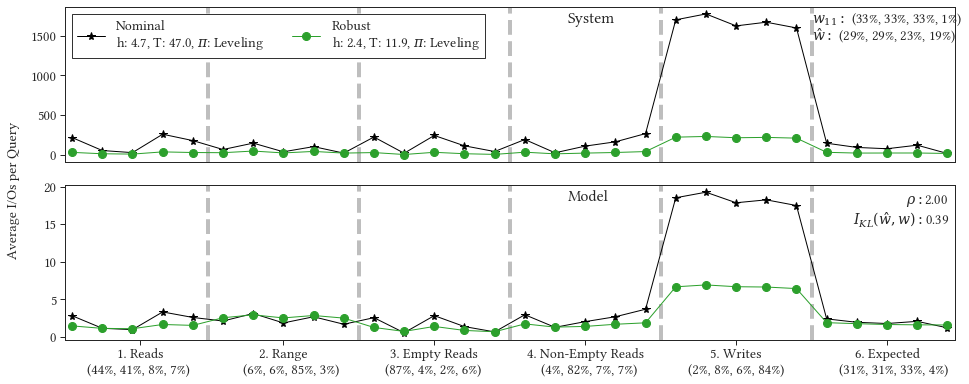

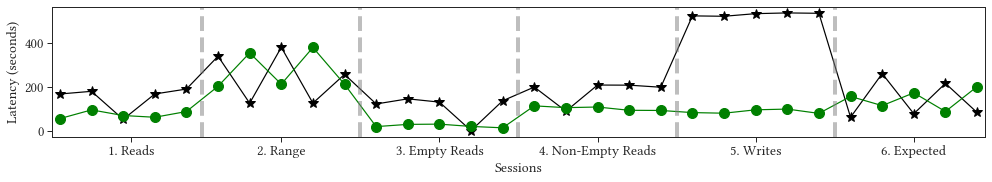

In [33]:
N, wl_idx = 1e7, 11
d = data[(data.workload_idx == wl_idx) & (data.N == N)].reset_index()
fig, axes = plot_cost_sessions(d, samples, num_operations, wl_idx, robust_rho, readonly=False)
# axes[0].set_ylim([0, 160])
# axes[1].set_ylim([0, 160])
set_size(fig, width=2*7, height=2*2.75)

fig, ax = plt.subplots()
ax.plot(d.index.values, d['nominal_ms'] / 100, '-*', markersize=10, color='black')
ax.plot(d.index.values, d['robust_ms']  / 100, '-o', markersize=10, color='green')

bounds = [5, 10, 15, 20, 25]
ax.set_xlim(left=-0.25, right=29.25)
for bound in bounds:
    ax.axvline(x=bound - 0.5, linestyle='--', linewidth=4, color='tab:gray', alpha=0.5)

ax.set_xticks([4.5 / 2, (4.5 + 9.5) / 2, (9.5 + 14.5) / 2, (14.5 + 19.5) / 2, (19.5 + 24.5) / 2, (24.5 + 29.5) / 2])
ax.set_xticklabels(['1. Reads', '2. Range', '3. Empty Reads', '4. Non-Empty Reads', '5. Writes', '6. Expected'])

ax.set_ylabel('Latency (seconds)')
ax.set_xlabel('Sessions')
set_size(fig, width=14, height=2.75)